In [10]:
# Clustering

Clustering is the unsupervised learning task to organize a collection of data into groups

K-means Clustering: K-means is the most popular clustering method

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [11]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [12]:
df = sqlContext.createDataFrame([[0, 33.3, -17.5],
                              [1, 40.4, -20.5],
                              [2, 28., -23.9],
                              [3, 29.5, -19.0],
                              [4, 32.8, -18.84]
                             ],["other","lat", "long"])

In [13]:
df.show()

+-----+----+------+
|other| lat|  long|
+-----+----+------+
|    0|33.3| -17.5|
|    1|40.4| -20.5|
|    2|28.0| -23.9|
|    3|29.5| -19.0|
|    4|32.8|-18.84|
+-----+----+------+



In [14]:
from pyspark.ml.feature import VectorAssembler

In [15]:
vecAssembler = VectorAssembler(inputCols=["lat", "long"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show()

# the argument inputCols serves to tell VectoeAssembler 
# which particular columns in our dataframe are to be used as features.



+-----+----+------+-------------+
|other| lat|  long|     features|
+-----+----+------+-------------+
|    0|33.3| -17.5| [33.3,-17.5]|
|    1|40.4| -20.5| [40.4,-20.5]|
|    2|28.0| -23.9| [28.0,-23.9]|
|    3|29.5| -19.0| [29.5,-19.0]|
|    4|32.8|-18.84|[32.8,-18.84]|
+-----+----+------+-------------+



In [16]:
from pyspark.ml.clustering import KMeans

In [17]:
kmeans = KMeans(k=2, seed=1)  # 2 clusters here
model = kmeans.fit(new_df.select('features'))

# select('features') here serves to tell the algorithm 
# which column of the dataframe to use for clustering
# after Step 1 above, your original lat & long features are no more directly used.

In [18]:
transformed = model.transform(new_df)
transformed.show()  

#The last column of the transformed dataframe, prediction, 
#shows the cluster assignment - in my toy case, 
#I have ended up with 4 records in cluster #0 and 1 record in cluster #1.

+-----+----+------+-------------+----------+
|other| lat|  long|     features|prediction|
+-----+----+------+-------------+----------+
|    0|33.3| -17.5| [33.3,-17.5]|         0|
|    1|40.4| -20.5| [40.4,-20.5]|         1|
|    2|28.0| -23.9| [28.0,-23.9]|         0|
|    3|29.5| -19.0| [29.5,-19.0]|         0|
|    4|32.8|-18.84|[32.8,-18.84]|         0|
+-----+----+------+-------------+----------+



In [19]:
df.select('lat', 'long').rdd.collect()

# When you select columns from a dataframe to convert to RDD, as you do, 
# the result is an RDD of Rows:

[Row(lat=33.3, long=-17.5),
 Row(lat=40.4, long=-20.5),
 Row(lat=28.0, long=-23.9),
 Row(lat=29.5, long=-19.0),
 Row(lat=32.8, long=-18.84)]

In [20]:
df.select('lat', 'long').rdd.map(lambda x: (x[0], x[1])).collect()

#above Rdd format is not suitable as an input to MLlib KMeans. 
#You'll need a map operation for this to work:

[(33.3, -17.5), (40.4, -20.5), (28.0, -23.9), (29.5, -19.0), (32.8, -18.84)]

In [21]:
from pyspark.mllib.clustering import KMeans, KMeansModel

rdd = df.select('lat', 'long').rdd.map(lambda x: (x[0], x[1]))
clusters = KMeans.train(rdd, 2, maxIterations=10, initializationMode="random")

In [22]:
clusters.centers

[array([ 30.1 , -20.58]), array([ 36.85, -19.  ])]

In [25]:
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()

# Convert rdd into Spark DataFrame

rdd_df = spark.createDataFrame(rdd, schema=["col1", "col2"])

# Convert Spark DataFrame into Pandas DataFrame
rdd_df_pandas = rdd_df.toPandas()

# Convert "cluster_centers" that you generated earlier into Pandas DataFrame
cluster_centers_pandas = pd.DataFrame(clusters.centers, columns=["col1", "col2"])

cluster_centers_pandas.head()



,col1,col2
0,30.10,-20.58
1,36.85,-19.00


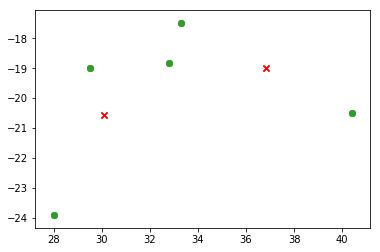

In [31]:
# Create an overlaid scatter plot
plt.scatter(rdd_df_pandas["col1"], rdd_df_pandas["col2"])

plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()